### Notes:

In this notebook, we calculate multi-touch attribution values for a given set of channels using following methods:
1. Shapley values - considering only positive conversions
2. Shapley values - considering both positive and negative conversions
3. Markov chain values 
4. Last touch based 

* Shapley values code is implemented based on the logic presented in this [paper](https://arxiv.org/pdf/1804.05327.pdf)
* Markov chain values are based on the following [whitepaper](https://www.channelattribution.net/pdf/Whitepaper.pdf)

Setup:
1. This code runs in AWS Sagemaker.
2. Input data is to be prepared using Rudderstack Reverse ETL (more details in accompanying blogpost)
3. Edit constants in the cell below. Only the first cell requires editing. No other edit is necessary. 
4. The output results get posted as a parquet file in the given output. The same can also be viewed in the notebook itself, as we go towards the end. 
5. Throughout the notebook, along with the code, we can also see several descriptions around the data and the results.
6. Towards the end, we also have a robustness check to ensure how robust the results are if input data changes.

### Part I: Constants:

Define constants below

In [1]:
# AWS DATA BUCKET where both input data is stored, and output data should be stored.
S3_BUCKET = 'dileep-dev'

# INPUT DATA LOCATION. Folder within aws bucket where input data is stored as json files (extracted from Rudderstack Reverse ETL)
S3_INPUT_FOLDER_LOCATION = 'rudder_wh_actions_usecases_attribution_raw_data'
# INPUT LABEL LOCATION. Folder within aws bucket where input label data is stored as json files (extracted from Rudderstack Reverse ETL)
S3_LABEL_DATA_FOLDER_LOCATION = 'rudder_wh_actions_usecases_attribution_label_data'

# Output location. Folder within aws bucket where output data 
S3_OUTPUT_FOLDER_LOCATION='rudder_wh_actions_usecases_attribution_multitouch_attribution'

# MODEL CONFIGURATION.

# The input data may sometimes contain a touch that is not required and you choose to drop them. 
# Such touches should be added to this list. 
# If all touches should be considered, we can pass an empty list (ex: IGNORE_TOUCHES=[])
IGNORE_TOUCHES = ["request-demo", 'marketing_newsletter_sent', 'marketing_campaign_sent', 'marketing_newsletter_clicked', 'marketing_campaign_clicked']


# We may want to combine a few touches into one group. Ex: all video ads from different sources may be combined into one.
# In such case, we make below flag True (else, False) and create a touchpoint_mapping dictionary (see below) to group related touch points together
GROUP_TOUCHES = True

# This is required only if GROUP_TOUCHES = True. In below mapping, each key corresponds to a touch we want to group. 
# Ex, sources, directory, home etc are all converted to 'webapp' and video-library, guides, case-studies are converted to 'docs'
# If a touch is not found in the key, no modification is applied on that and it stays as is.
touchpoint_mapping = {"":"webapp",
                      "others": None,
                      "sources": "webapp",
                      "directory": "webapp",
                      "home": "webapp",
                      "signup": None,
                      "destinations": "webapp",
                      "integration": "product",
                      "login": None,
                      "syncs": "webapp",
                      "profile": None,
                      "transformations": "product",
                      "team": "webapp",
                      "rudderstack-vs-segment": None,
                      "video-library": "docs",
                      "guides": "docs",
                      "rudderstack-vs-snowplow": None,
                      'case-studies': 'docs', 
                      'join-rudderstack-slack': 'join_slack', 
                      'join-rudderstack-slack-community': 'join_slack'}

#touchpoint_mapping = None # If no mapping is required.

# Ignores any data before this date. If not required, we can give it as None
MIN_DATE = '2021-06-01'
#MIN_DATE = None # If not required

# Dedup logic. IF same event repeats consecutively within this interval (in seconds), they are considered the same and first occurence timestamp is counted. 
# If we don't want a dedup logic, we can make this value as 0.
MIN_EVENT_INTERVAL_IN_SEC = 300




**No other manual change is expected. Rest of the code should run without any edit.**

You can run the whole notebook by going to `Run -> Run all cells`. This creates the parquet file output in prescribed s3 location, and also prints the data here for instant consumption

### Part II: Data Preprocessing:

In [2]:
# Loading the required libraries
import json
import boto3
import os
import sys
import gzip
from typing import List, Optional, Union, Dict, Tuple
import datetime

from math import factorial
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import logging
import yaml
import itertools
from dataclasses import dataclass
pd.set_option('display.max_columns', None)


from tqdm import tqdm
tqdm.pandas()

In [3]:

# Helper functions to load input data
def load_json(json_str: str,
              key: Optional[str]=None):
    if key:
        return json.loads(json_str)[key]
    else:
        return json.loads(json_str)

def load_s3_compressed_dictionary_object(s3_file_object, key: Optional[str]=None):
    with gzip.GzipFile(fileobj=s3_file_object.get()['Body']) as gzipfile:
        content = gzipfile.read().decode('utf-8').split('\n')
    
    return [load_json(line, key) for line in content if line]

def load_json_data_from_s3(s3_instance, s3_bucket_name: str, files_prefix: str, json_dict_key: Optional[str]=None) -> pd.DataFrame:
    bucket = s3_instance.Bucket(s3_bucket_name)
    all_rows = []
    for file_obj in tqdm(bucket.objects.filter(Prefix=files_prefix)):
        all_rows.append(load_s3_compressed_dictionary_object(file_obj, json_dict_key))
    
    df = pd.DataFrame.from_records([row for rows in all_rows for row in rows])
    df.columns = [col.lower() for col in list(df)]
    return df


In [4]:
%%time
# Loading data from Reverse ETL output into Python
s3 = boto3.resource("s3")

raw_data = load_json_data_from_s3(s3, S3_BUCKET, S3_INPUT_FOLDER_LOCATION, json_dict_key='traits')
raw_data["timestamp"] = pd.to_datetime(raw_data["timestamp"]).dt.tz_localize(None)

label_data = load_json_data_from_s3(s3, S3_BUCKET, S3_LABEL_DATA_FOLDER_LOCATION, json_dict_key='traits')
label_data['call_conversion_time'] = pd.to_datetime(label_data['call_conversion_time']).dt.tz_localize(None)

51it [00:18,  2.78it/s]
1it [00:00, 10.99it/s]

CPU times: user 17 s, sys: 1.05 s, total: 18 s
Wall time: 20.9 s


In [5]:
domain_conversion_dates = label_data.set_index("domain").to_dict()['call_conversion_time']
raw_data = raw_data.drop(columns=['row_id', 'call_conversion_time']).drop_duplicates()

In [6]:
# Transformations on the raw data. We apply the constraints defined in the constants cell above.

def dedup_by_ts_delta(df: pd.DataFrame, primary_key: str, timestamp: str, event_type: str, max_lag: int) -> pd.DataFrame:
    """
    ### Parameters
    1. df : pd.DataFrame
        - User touches dataframe. 
    2. primary_key : str
        - column name of the column that contains user_id. 
    3. timestamp: str
        - column name of the column that contains event timestamp
    4. event_type: str
        - column name of the column that contains event/touch data
    5. max_lag: int
        - max time (in sec) between consecutive events to be considered as duplicates. 

    ### Returns
    - DataFrame after doing following steps
    Based on primary key and event_type, it checks if two consecutive events occur within the max_lag time window. If so, they are considered same event and the latter event is dropped. 
    """
    if max_lag <= 0:
        return df
    df = df.sort_values(by=[primary_key, timestamp], ascending=True).reset_index(drop=True)
    original_columns = df.columns
    df["prev_user"] = df[primary_key].shift()
    df["prev_event"] = df[event_type].shift()
    df["prev_ts"] = df[timestamp].shift()

    def is_duplicate(row):
        if pd.isnull(row["prev_user"]) or pd.isnull(row["prev_event"]) or pd.isnull(row["prev_ts"]):
            return False
        elif row[primary_key] == row["prev_user"] and row[event_type] == row["prev_event"] and (
                row[timestamp] - row["prev_ts"]).total_seconds() <= max_lag:
            return True
        else:
            return False

    df["is_duplicate"] = df.progress_apply(is_duplicate, axis=1)
    return df.query("is_duplicate==False")[original_columns].reset_index(drop=True)

def process_raw_data(raw_data_df: pd.DataFrame,
                     ignore_touches: List[str],
                     min_date: Optional[str],
                     dedup_min_time: int,
                     reduce_touches: bool = True) -> pd.DataFrame:
    """
    ### Parameters
    1. raw_data_df : Raw data 
    2. ignore_touches: Ignores the touches present in this list. 
    3. min_date: Ignores events before this date
    4. dedup_min_time: Time (in sec) between two events of same type. Events that repeat within this interval are combined as one (earlier timestamp is considered)
    5. reduce_touches : Whether to combine touchpoints based on their logical groupings

    ### Returns
    - DataFrame after doing following steps
    1. Groups tracks pages if reduce_touches flag is True
    2. Deduplicates based on 5 min interval 
    3. Ignores touches based on ignore_touches list
    4. Ðrops events before the min_date timestamp.
    """
    if reduce_touches:
        raw_data_df["touch"] = raw_data_df["touch"].apply(lambda touch: touchpoint_mapping.get(touch, touch))
    
    dedup_data_df = (dedup_by_ts_delta(raw_data_df
                                       .query("~touch.isnull()",
                                              engine='python')
                                       .drop_duplicates(),
                                       "domain",
                                       "timestamp", 
                                       "touch", 
                                       dedup_min_time)
                     .filter(['domain', 'touch', 'timestamp', 'is_mql', 'touch_category'])
                    )
    if min_date:
        return dedup_data_df.query(f'touch not in @ignore_touches and timestamp >= "{min_date}"', engine='python')
    else:
        return dedup_data_df.query(f'touch not in @ignore_touches', engine='python')

In [7]:
%%time
touch_data_filtered = process_raw_data(raw_data, IGNORE_TOUCHES, MIN_DATE, MIN_EVENT_INTERVAL_IN_SEC, GROUP_TOUCHES)
del raw_data

100%|██████████| 717733/717733 [00:51<00:00, 14046.00it/s]


CPU times: user 54 s, sys: 240 ms, total: 54.2 s
Wall time: 54.2 s


In [8]:
# Combining the label data to events data
touch_data_filtered['is_converted'] = touch_data_filtered['domain'].apply(lambda domain: 1 if domain in domain_conversion_dates else 0)

In [9]:
# Sample data:
touch_data_filtered.head()

,domain,touch,timestamp,is_mql,touch_category,is_converted
0,.company.com,join_slack,2021-12-15 10:44:50.051,NaN,tracks,0
1,.company.com,form_submit,2021-12-15 10:46:43.004,NaN,signup,0
2,.company.com,join_slack,2021-12-15 10:49:25.341,NaN,tracks,0
30,100xbit.com,sf_outbound_email,2021-08-09 07:00:00.000,0.0,sales,0
31,100xbit.com,user_signed_up,2021-08-09 15:55:39.069,0.0,signup,0


In [10]:
positive_touchpoints = touch_data_filtered.query("is_converted==1", engine='python').rename(columns={"touch": "event_type"})
negative_touchpoints = touch_data_filtered.query("is_converted==0", engine='python').rename(columns={"touch": "event_type"})

print("Summary stats on converted and non converted journeys:\n")
print(f"Total rows in converted journeys: {len(positive_touchpoints)}")
print(f"Distinct converted journeys: {len(positive_touchpoints['domain'].unique())}")
print(f"Total rows in non-converted journeys: {len(negative_touchpoints)}")
print(f"Distinct non-converted journeys: {len(negative_touchpoints['domain'].unique())}")


Summary stats on converted and non converted journeys:

Total rows in converted journeys: 10678
Distinct converted journeys: 275
Total rows in non-converted journeys: 146828
Distinct non-converted journeys: 5822


### Part III: Data distribution (Optional)

A few stats on the converted journeys before going into the actual attribution problem:

Note: This section is not required to calculate the attribution values. Instead, it is just to show the distribution of no:of events and no:of days before users convert. You can skip directly to [Part IV](#MTA-Calculations-begin)

In [11]:
conversion_summary = positive_touchpoints.query("event_type!='webapp'").groupby(["domain"]).agg({"timestamp": "min", "event_type":["size", "nunique"]}).reset_index()
conversion_summary.columns = ["domain", "timestamp", "n_events", "n_distinct_events"]
conversion_summary["days_to_convert"] = conversion_summary.apply(lambda row: (domain_conversion_dates.get(row['domain']) - row["timestamp"]).days, axis=1)

conversion_summary.head()

,domain,timestamp,n_events,n_distinct_events,days_to_convert
0,30lines.com,2021-12-07 10:12:01.727,10,5,30
1,aadarniy.com,2021-09-04 18:29:59.748,4,4,10
2,ablejobs.co,2021-09-13 07:00:00.000,4,3,2
3,ably.com,2021-10-28 23:53:44.063,59,8,49
4,accurx.com,2021-11-13 01:32:59.213,33,8,17


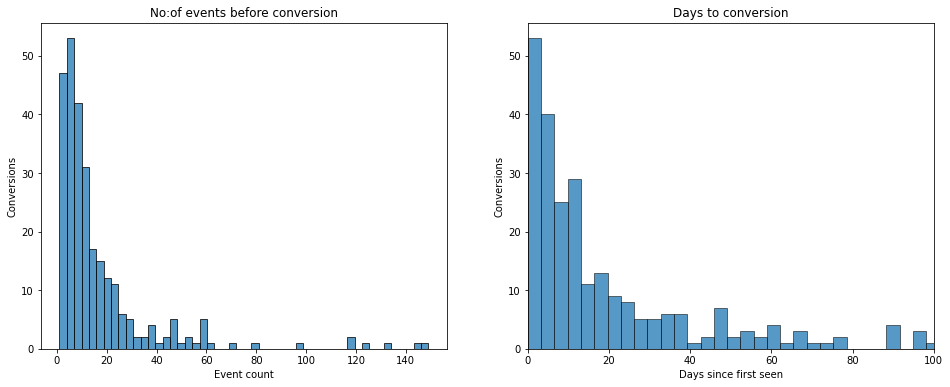

In [12]:
fig, axs = plt.subplots(1,2,figsize=(16,6))
sns.histplot(conversion_summary["n_events"], bins=50, ax=axs[0])
axs[0].set_title("No:of events before conversion")
axs[0].set_ylabel("Conversions")
axs[0].set_xlabel("Event count");

sns.histplot(conversion_summary["days_to_convert"], bins=70, ax=axs[1])
axs[1].set_title("Days to conversion")
axs[1].set_ylabel("Conversions")
axs[1].set_xlim([0,100])
axs[1].set_xlabel("Days since first seen");

In [13]:
# Checks percentile counts at various levels. Can modify this list to get a different percentile value (ex: For 90th percentile, add 90 to the list.)
percentile_points = [0,5, 25, 50, 75, 95, 99, 100]

In [14]:
print(f"Avg no:of touches before a user converts: {conversion_summary['n_events'].mean():.2f}; Median: {np.median(conversion_summary['n_events'])}")
print("\nPercentiles for No:of touches:")
(pd.DataFrame.from_dict(
    dict(zip(percentile_points, 
             np.percentile(conversion_summary['n_events'],
                           percentile_points).round())),
    orient='index', 
    columns=['n_events'])
 .reset_index().rename(columns={"index":"percentile"}))

Avg no:of touches before a user converts: 16.68; Median: 9.0

Percentiles for No:of touches:


,percentile,n_events
0,0,1.0
1,5,2.0
2,25,5.0
3,50,9.0
4,75,19.0
5,95,58.0
6,99,126.0
7,100,149.0


In [15]:
print(f"Avg days to convert: {conversion_summary['days_to_convert'].mean():.2f}; Median: {np.median(conversion_summary['days_to_convert'])}")
print("\nPercentiles for No:of days to convert:")
(pd.DataFrame.from_dict(
    dict(zip(percentile_points, 
             np.percentile(conversion_summary['days_to_convert'],
                           percentile_points).round())),
    orient='index', 
    columns=['n_days_to_convert'])
 .reset_index().rename(columns={"index": "percentile"}))

Avg days to convert: 32.42; Median: 13.0

Percentiles for No:of days to convert:


,percentile,n_days_to_convert
0,0,0.0
1,5,1.0
2,25,5.0
3,50,13.0
4,75,36.0
5,95,133.0
6,99,215.0
7,100,229.0


<a id='MTA-Calculations-begin'></a>

### Part IV: Shapley values calculation


In [16]:
## Helper function to transform data to the required input form 

def collect_touchpoints(touchpoints_df: pd.DataFrame, 
                        primary_key: str="domain", 
                        ts_column: str="timestamp",
                        touchpoint_column: str="event_type") -> pd.DataFrame:
    """
    Transform dataframe with each touch as a row to a new dataframe where each journey has a single row with all touches as a list in chronological order
    touchpoints_df: A dataframe with each row corresponding to a touch. 
    primary_key: Name of the column containing unique user identifier
    ts_column: Name of column containing timestamp using which journeys are sorted chronologically
    touchpoint_column: Name of column containing touch points. 
    
    Returns:
    A dataframe with two columns, first has primary key and second has the touchpoint_column
    """
    return (touchpoints_df
            .sort_values(by=[primary_key, ts_column], 
                         ascending=True)
            .reset_index(drop=True)
            .groupby(primary_key)[touchpoint_column]
            .apply(list)
            .reset_index())

In [17]:
touchpoints_list_pos = collect_touchpoints(positive_touchpoints)

touchpoints_list_pos.head()

,domain,event_type
0,30lines.com,"[pricing, docs, webapp, blog, docs, docs, sf_o..."
1,aadarniy.com,"[webapp, user_signed_up, webapp, webapp, marke..."
2,ablejobs.co,"[sf_outbound_email, webapp, user_signed_up, we..."
3,ably.com,"[webapp, form_submit, marketing_newsletter_ope..."
4,accurx.com,"[pricing, docs, webapp, pricing, docs, pricing..."


In [18]:


# Computing normalizing factor for marginal contribution
shapley_weight = lambda p, s: (factorial(s)*factorial(p-s-1)/factorial(p))

# Getting shapley value of a given channel and values mapping for channel subsets.
def compute_shapley_values(v_values_map: dict, 
                            channel: str,
                            n_channels: int) -> float:
    # Initiating shap with marginal contribution from S = null subset
    shap = 1/n_channels * v_values_map.get(channel, 0) 
    for subset_str, subset_contrib in v_values_map.items():
        subset = subset_str.split(",")
        if channel not in subset:
            subset_union_channel = ','.join(sorted(subset + [channel]))
            marginal_contrib = (v_values_map.get(subset_union_channel,0) -
                                v_values_map.get(subset_str,0))
            shap += shapley_weight(n_channels, len(subset)) * marginal_contrib
    
    return shap

# Helper function to generate subsets for a given set of channels
def generate_subsets(touchpoints: List[str]) -> List[List[str]]:
    subset_list = []
    for subset_size in range(len(touchpoints)):
        for subset in itertools.combinations(touchpoints, subset_size + 1):
            subset_list.append(list(sorted(subset)))
    return subset_list

# Computes the utility function value v(s) for given subset S, using contribution values for all subsets.
def utility_function(touchpoint_set: List[str], 
                     contributions_mapping: dict) -> Union[int, float]:
    subset_list = generate_subsets(touchpoint_set)
    return sum([contributions_mapping.get(','.join(subset),0) for subset in subset_list])


# Master function combining all the above functions to compute shapley values for each touchpoint from a list of journeys. 
def get_shapley_values(journeys_list: List[List[str]], 
                       contribs_list: List[Union[int, float]])->Dict[str, float]:
    """

    Args:
        journeys_list (List[List[str]]): List of journeys.
         Each journey is a list of touchpoints..
        contribs_list (List[Union[int, float]]): List of contributions corresponding to each journey in journeys_list.
         Should have same length as journeys_list

    Returns:
        Dict[str, float]: A dictionary with key as channel/touchpoint, and Shapley value as its value 
    """
    flattened_journeys = [channel for journey in journeys_list for channel in set(journey)]
    unique_channels = sorted(list(set(flattened_journeys)))
    all_subsets = generate_subsets(unique_channels)
    contrib_map = {}
    for n, journey in enumerate(journeys_list):
        journey_ = ",".join(sorted(set(journey))) # Ensures deduplication and sorting of journeys
        contrib_map[journey_] = contrib_map.get(journey_,0) + contribs_list[n]
    v_values = {}
    for subset in all_subsets:
        v_values[",".join(subset)] = utility_function(subset, contrib_map)
        
    shapley_values = {}
    for channel in unique_channels:
        shapley_values[channel] = compute_shapley_values(v_values, 
                                                          channel, 
                                                          len(unique_channels))
    return shapley_values
    

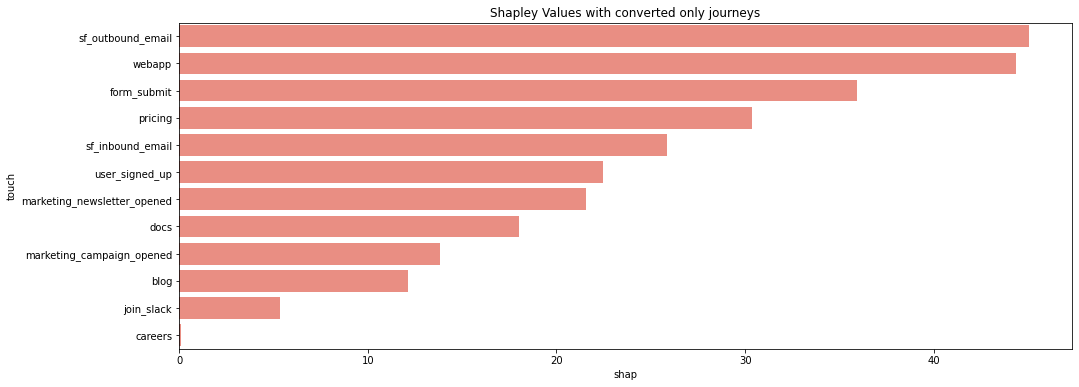

In [19]:
touches_shapley_values = get_shapley_values(touchpoints_list_pos['event_type'].values, [1] * len(touchpoints_list_pos))
touches_shapley_values = pd.DataFrame.from_dict(touches_shapley_values, orient="index").reset_index()
touches_shapley_values.columns = ["touch", "shap"]
touches_shapley_values = touches_shapley_values.sort_values(by= 'shap', ascending=False).reset_index(drop=True)
plt.figure(figsize=(16,6))
sns.barplot(x="shap", y="touch", data=touches_shapley_values, color="salmon")
plt.title("Shapley Values with converted only journeys");

In [20]:
touches_shapley_values

,touch,shap
0,sf_outbound_email,45.072835
1,webapp,44.358550
2,form_submit,35.907756
3,pricing,30.368074
4,sf_inbound_email,25.875613
5,user_signed_up,22.464899
6,marketing_newsletter_opened,21.572835
7,docs,18.017280
8,marketing_campaign_opened,13.799423
9,blog,12.127597


**Shapley values including negative paths**

In [21]:

def aggregate_by_journeys(touchpoints_df, identifier_col, touches_col):
    """
    Returns a dataframe where each row contains a sorted list of touchpoints and count of how many times this journey is observed.
    Within a journey, order of touches is ignored and a touch is counted only once.
    """
    return (touchpoints_df
            .groupby(identifier_col)[touches_col]
            .apply(list)
            .apply(lambda x: ",".join(sorted(list(set(x)))))
            .reset_index()
            .groupby(touches_col)
            .size()
            .reset_index())

In [22]:
pos_data_counts = aggregate_by_journeys(positive_touchpoints, "domain", "event_type")
neg_data_counts = aggregate_by_journeys(negative_touchpoints, "domain", "event_type")
pos_data_counts.columns = ['events', 'conversions']
neg_data_counts.columns = ['events', 'non_conversions']

all_data_counts = pos_data_counts.merge(neg_data_counts, on="events", how="outer").fillna(0)
all_data_counts["conversion_rate"] = all_data_counts.apply(lambda row: row["conversions"]/(row["conversions"] + row["non_conversions"]), axis=1)
all_data_counts['events'] = all_data_counts['events'].apply(lambda x: x.split(","))
del pos_data_counts, neg_data_counts



In [23]:
all_data_counts.head()

,events,conversions,non_conversions,conversion_rate
0,"[blog, careers, docs, form_submit, join_slack,...",1.0,1.0,0.500000
1,"[blog, docs, form_submit, join_slack, marketin...",6.0,19.0,0.240000
2,"[blog, docs, form_submit, join_slack, marketin...",2.0,21.0,0.086957
3,"[blog, docs, form_submit, join_slack, marketin...",1.0,2.0,0.333333
4,"[blog, docs, form_submit, join_slack, marketin...",1.0,1.0,0.500000


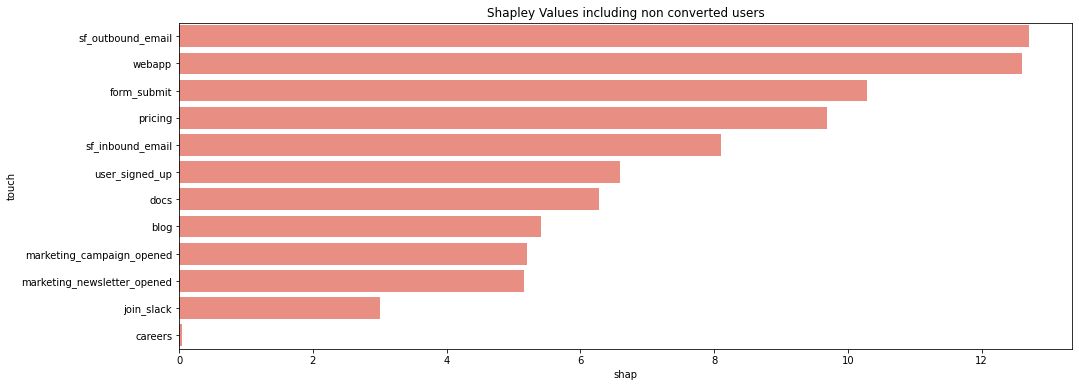

In [24]:
touches_shapley_values_all_paths = get_shapley_values(all_data_counts['events'].values, all_data_counts['conversion_rate'])

touches_shapley_values_all_paths = pd.DataFrame.from_dict(touches_shapley_values_all_paths, orient="index").reset_index()
touches_shapley_values_all_paths.columns = ["touch", "shap"]
touches_shapley_values_all_paths = touches_shapley_values_all_paths.sort_values(by= 'shap', ascending=False).reset_index(drop=True)
plt.figure(figsize=(16,6))
sns.barplot(x="shap", y="touch", data=touches_shapley_values_all_paths, color="salmon")
plt.title("Shapley Values including non converted users");

In [25]:
# Merging both forms of shapley values
touches_shapley_values_all_paths['shap'] = touches_shapley_values_all_paths['shap']/touches_shapley_values_all_paths['shap'].sum()
touches_shapley_values['shap_normalized'] = touches_shapley_values['shap']/touches_shapley_values['shap'].sum()

In [26]:
mta_vals = (touches_shapley_values_all_paths
            .rename(columns={"shap":"shap_all_paths"})
            .merge(touches_shapley_values
                   .filter(["touch", "shap_normalized"])
                   .rename(columns={'shap_normalized':'shap_conversions'}),
                   on='touch'))
mta_vals

,touch,shap_all_paths,shap_conversions
0,sf_outbound_email,0.149505,0.163901
1,webapp,0.148110,0.161304
2,form_submit,0.120913,0.130574
3,pricing,0.113862,0.110429
4,sf_inbound_email,0.095188,0.094093
5,user_signed_up,0.077494,0.081691
6,docs,0.073805,0.065517
7,blog,0.063602,0.044100
8,marketing_campaign_opened,0.061114,0.050180
9,marketing_newsletter_opened,0.060666,0.078447


### Part V: Markov Chain Values Calculation

Index of transition counts: 1st: source, last: destination. 2 to -1: same order as dict_touches_inv keys

In [27]:
touchpoints_list_neg = collect_touchpoints(negative_touchpoints)

all_touches = list(positive_touchpoints["event_type"].unique())


In [28]:

def generate_transition_counts(journey_list: List[List[str]], 
                               distinct_touches_list: List[str], 
                               is_positive: bool):
    if is_positive:
        destination_idx = -1
    else:
        destination_idx = -2
    transition_counts = np.zeros(((len(distinct_touches_list)+3), (len(distinct_touches_list)+3)))
    for journey in journey_list:
        transition_counts[0, (distinct_touches_list.index(journey[0])+1)] += 1 # First point in the path
        for n, touch_point in enumerate(journey):
            if n == len(journey) - 1:
                # Reached last point
                transition_counts[(distinct_touches_list.index(touch_point)+1), destination_idx] += 1
                transition_counts[destination_idx, destination_idx]+=1
            else:
                transition_counts[(distinct_touches_list.index(touch_point)+1), (distinct_touches_list.index(journey[n+1]) + 1)] +=1
    transition_labels = distinct_touches_list.copy()
    transition_labels.insert(0, "Start")
    transition_labels.extend(["Dropoff", "Converted"])
    return transition_counts, transition_labels

row_normalize_np_array = lambda transition_counts: transition_counts / transition_counts.sum(axis=1)[:, np.newaxis]

def plot_transitions(transition_probabilities: np.array, labels: List[str], title="Transition Probabilities", show_annotations=True):
    ax = sns.heatmap(transition_probabilities,
                     linewidths=0.5,
                     robust=True, 
                     annot_kws={"size":8}, 
                     annot=show_annotations,
                     fmt=".2f",
                     cmap="YlGnBu",
                     xticklabels=labels,
                     yticklabels=labels)
    ax.tick_params(labelsize=10)
    ax.figure.set_size_inches((16, 10))
    ax.set_ylabel("Previous Step")
    ax.set_xlabel("Next Step")
    ax.set_title(title);


def get_transition_probabilities(converted_touchpoints_list: List[List[int]], 
                                 dropoff_touchpoints_list: List[List[int]], 
                                 distinct_touches_list: List[str], 
                                 visualize=False) -> Tuple[np.array, List[str]]:
    pos_transitions, _ = generate_transition_counts(converted_touchpoints_list, distinct_touches_list, is_positive=True)
    neg_transitions, labels = generate_transition_counts(dropoff_touchpoints_list, distinct_touches_list, is_positive=False)
    all_transitions = pos_transitions + neg_transitions
    transition_probabilities = row_normalize_np_array(all_transitions)
    if visualize:
        plot_transitions(transition_probabilities, labels, show_annotations=True)
    return transition_probabilities, labels

def converge(transition_matrix, max_iters=200, verbose=True):
    T_upd = transition_matrix
    prev_T = transition_matrix
    for i in range(max_iters):
        T_upd = np.matmul(transition_matrix, prev_T)
        if np.abs(T_upd - prev_T).max()<1e-5:
            if verbose:
                print(f"{i} iters taken for convergence")
            return T_upd
        prev_T = T_upd
    if verbose:
        print(f"Max iters of {max_iters} reached before convergence. Exiting")
    return T_upd


def get_removal_affects(transition_probs, labels, ignore_labels=["Start", "Dropoff","Converted"], default_conversion=1.):
    removal_affect = {}
    for n, label in enumerate(labels):
        if label in ignore_labels:
            continue
        else:
            drop_transition = transition_probs.copy()
            drop_transition[n,:] = 0.
            drop_transition[n,-2] = 1.
            drop_transition_converged = converge(drop_transition, 500, False)
            removal_affect[label] = default_conversion - drop_transition_converged[0,-1]
    return removal_affect

def get_markov_attribution(tp_list_positive: List[List[int]],
                           tp_list_negative: List[List[int]], 
                           distinct_touches_list: List[str], 
                           visualize=False) -> Tuple[Dict[str, float], np.array]:
    transition_probabilities, labels = get_transition_probabilities(tp_list_positive, tp_list_negative, distinct_touches_list, visualize=visualize)
    transition_probabilities_converged = converge(transition_probabilities, max_iters=500, verbose=False)
    removal_affects = get_removal_affects(transition_probabilities, labels, default_conversion=transition_probabilities_converged[0,-1])
    total_conversions = len(tp_list_positive)
    attributable_conversions = {}
    total_weight = sum(removal_affects.values())
    for tp, weight in removal_affects.items():
        attributable_conversions[tp] = weight/total_weight * total_conversions
    return attributable_conversions, transition_probabilities


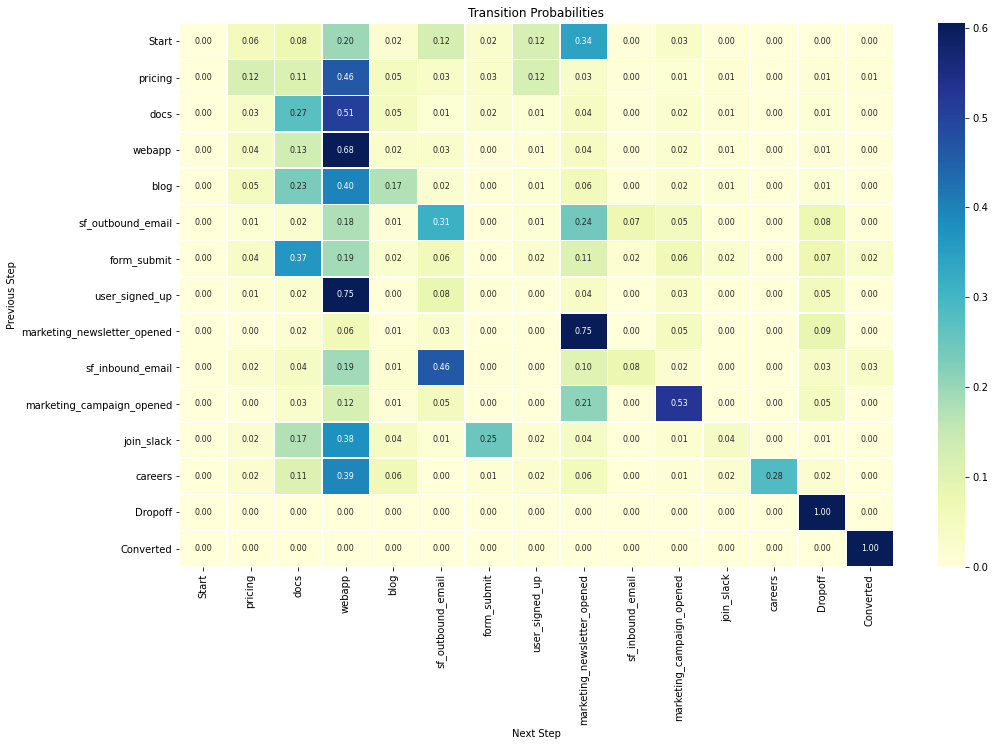

In [29]:
markov_attribution_values, transition_probabilities = get_markov_attribution(touchpoints_list_pos["event_type"].values, touchpoints_list_neg["event_type"].values, all_touches, visualize=True)

In the above graphic, we can see the transition probabilities from each touch (Y-axis) to the next touch (X-axis). 

In [30]:
pos_transitions, labels = generate_transition_counts(touchpoints_list_pos["event_type"].values, all_touches, is_positive=True)
neg_transitions, labels = generate_transition_counts(touchpoints_list_neg["event_type"].values, all_touches, is_positive=False)
all_transitions = pos_transitions + neg_transitions

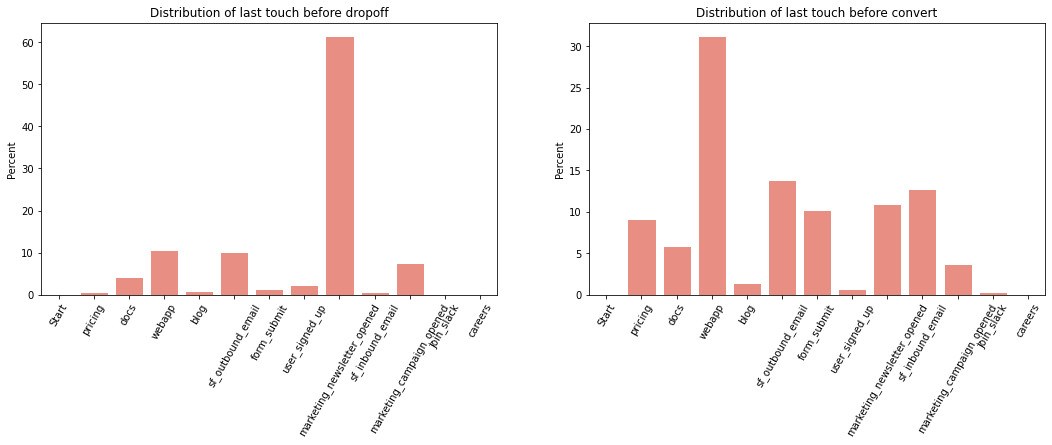

In [31]:

fig, axs=plt.subplots(1,2, figsize=(18, 5))
sns.set_style("white")
sns.barplot(x=labels[:-2], y=100*all_transitions[:-2, -2]/all_transitions[:-2, -2].sum(), ci=None, color="salmon", ax=axs[0])
    
axs[0].set_xticklabels(labels[:-2],rotation=60)
axs[0].set_ylabel("Percent")
axs[0].set_title("Distribution of last touch before dropoff");

sns.barplot(x=labels[:-2], y=100*all_transitions[:-2, -1]/all_transitions[:-2, -1].sum(), ci=None, color="salmon", ax=axs[1])
axs[1].set_xticklabels(labels[:-2],rotation=60)
axs[1].set_ylabel("Percent")
axs[1].set_title("Distribution of last touch before convert");

### Part VI: Results summary

In [32]:
last_touch_based_mta = touchpoints_list_pos["event_type"].apply(lambda event_list: event_list[-1]).value_counts().reset_index()
last_touch_based_mta.columns = ['touch', 'last_touches']
last_touch_based_mta['last_touches'] = last_touch_based_mta['last_touches']/last_touch_based_mta['last_touches'].sum()

markov_attr_values_df = pd.DataFrame.from_dict(markov_attribution_values, orient="index").reset_index()
markov_attr_values_df.columns = ["touch", "markov"]
markov_attr_values_df['markov'] = markov_attr_values_df['markov']/markov_attr_values_df['markov'].sum()
mta_values = markov_attr_values_df.merge(mta_vals, on="touch", how="outer").merge(last_touch_based_mta, on='touch',how='outer').fillna(0)

In [33]:
mta_values

,touch,markov,shap_all_paths,shap_conversions,last_touches
0,pricing,0.097309,0.113862,0.110429,0.090909
1,docs,0.139174,0.073805,0.065517,0.058182
2,webapp,0.171497,0.148110,0.161304,0.312727
3,blog,0.074148,0.063602,0.044100,0.014545
4,sf_outbound_email,0.112860,0.149505,0.163901,0.138182
5,form_submit,0.048850,0.120913,0.130574,0.101818
6,user_signed_up,0.066336,0.077494,0.081691,0.007273
7,marketing_newsletter_opened,0.129628,0.060666,0.078447,0.109091
8,sf_inbound_email,0.048805,0.095188,0.094093,0.127273
9,marketing_campaign_opened,0.083320,0.061114,0.050180,0.036364


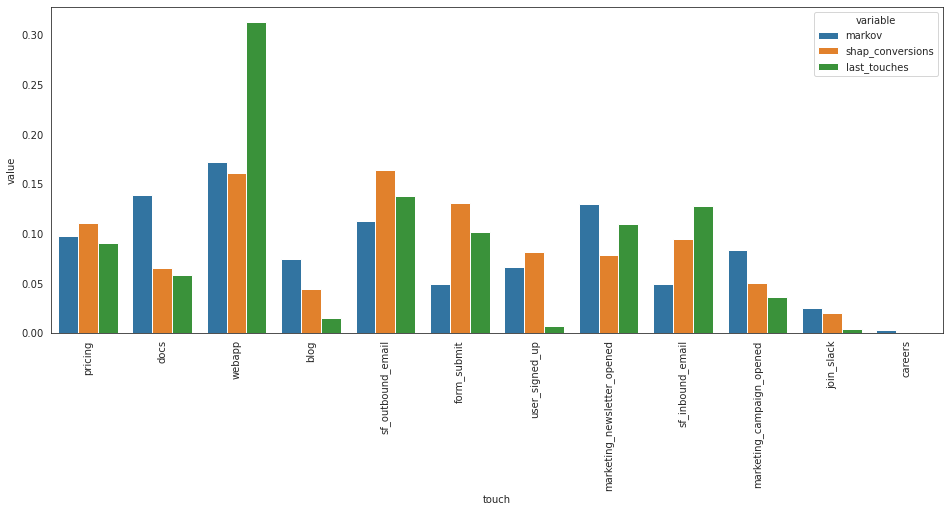

In [34]:
mta_long = pd.melt(mta_values, "touch", ["markov",  "shap_conversions", "last_touches"])
plt.figure(figsize=(16,6))
sns.barplot(data=mta_long, x='touch',y='value',hue='variable');
plt.xticks(rotation=90);

In [35]:
mta_values.corr()

,markov,shap_all_paths,shap_conversions,last_touches
markov,1.000000,0.603563,0.611393,0.688180
shap_all_paths,0.603563,1.000000,0.979599,0.770143
shap_conversions,0.611393,0.979599,1.000000,0.807379
last_touches,0.688180,0.770143,0.807379,1.000000


In [36]:
time_suffix = datetime.datetime.strftime(datetime.datetime.now(), '%Y-%m-%dT%H:%M:%S')
output_location = f"s3://{S3_BUCKET}/{S3_OUTPUT_FOLDER_LOCATION}/{time_suffix}"

In [37]:
print(f"MTA values will be written to the location:\n\t{output_location}")

MTA values will be written to the location:
	s3://dileep-dev/rudder_wh_actions_usecases_attribution_multitouch_attribution/2022-02-03T06:55:38


In [38]:
mta_values.to_parquet(f"{output_location}/mta_values.parquet")

### Part VII: Robustness testing

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
markov_vals = {}
shapley_vals = {}

touchpoints_list_pos_rand1, touchpoints_list_pos_rand2 = train_test_split(touchpoints_list_pos, train_size=0.5)
touchpoints_list_neg_rand1, touchpoints_list_neg_rand2 = train_test_split(touchpoints_list_neg, train_size=0.5)

touches_shapley_values_rand1 = get_shapley_values(touchpoints_list_pos_rand1['event_type'].values, [1] * len(touchpoints_list_pos_rand1))
# get_shapley_values(touchpoints_list_pos_rand1["event_id"].values, dict_touches, visualize=False)
markov_attribution_values_rand1, _ = get_markov_attribution(touchpoints_list_pos_rand1["event_type"].values, touchpoints_list_neg_rand1["event_type"].values, all_touches, visualize=False)

touches_shapley_values_rand2 = get_shapley_values(touchpoints_list_pos_rand2['event_type'].values, [1] * len(touchpoints_list_pos_rand2))

markov_attribution_values_rand2, _ = get_markov_attribution(touchpoints_list_pos_rand2["event_type"].values, touchpoints_list_neg_rand2["event_type"].values, all_touches, visualize=False)


for key, val in touches_shapley_values_rand1.items():
    shapley_vals[key] = [val, touches_shapley_values_rand2.get(key,0)]

for key, val in markov_attribution_values_rand1.items():
    markov_vals[key] = [val, markov_attribution_values_rand2.get(key,0)]

    
shapley_vals_df = pd.DataFrame.from_dict(shapley_vals, orient='index')
markov_vals_df = pd.DataFrame.from_dict(markov_vals, orient='index')
print(f"Correlation of shapley values between two non-overlapping splits: {shapley_vals_df.corr()[0][1]:.3f}")
print(f"Correlation of markov values between two non-overlapping splits: {markov_vals_df.corr()[0][1]:.3f}")

Correlation of shapley values between two non-overlapping splits: 0.985
Correlation of markov values between two non-overlapping splits: 0.998


In [41]:
shapley_vals_df = pd.melt(shapley_vals_df.reset_index(), id_vars='index')
shapley_vals_df.columns = ['touch', 'iter', 'shap']

markov_vals_df = pd.melt(markov_vals_df.reset_index(), id_vars='index')
markov_vals_df.columns = ['touch', 'iter', 'markov']

tp_order = shapley_vals_df.groupby('touch')['shap'].mean().reset_index().sort_values("shap", ascending=False)['touch'].values

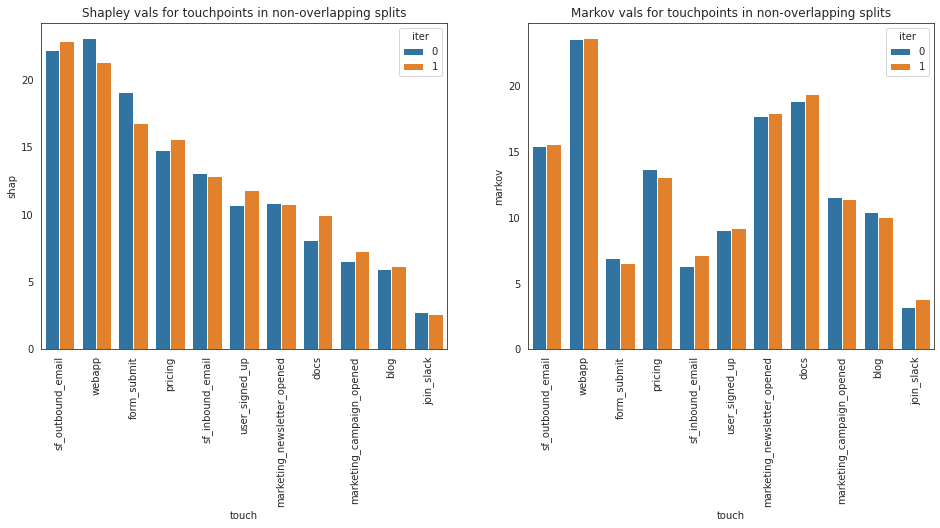

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))
sns.barplot(x='touch', y='shap', hue='iter', data=shapley_vals_df, ax=axs[0], order=tp_order)
for item in axs[0].get_xticklabels():
    item.set_rotation(90)
axs[0].set_title("Shapley vals for touchpoints in non-overlapping splits");

sns.barplot(x='touch', y='markov', hue='iter', data=markov_vals_df, ax=axs[1], order=tp_order)
for item in axs[1].get_xticklabels():
    item.set_rotation(90)
axs[1].set_title("Markov vals for touchpoints in non-overlapping splits");

In [43]:
markov_vals = {}
shapley_vals = {}
for iters in range(10):
    touchpoints_list_pos_rand, _ = train_test_split(touchpoints_list_pos, train_size=0.7)
    touchpoints_list_neg_rand, _ = train_test_split(touchpoints_list_neg, train_size=0.7)
    touches_shapley_values_rand = get_shapley_values(touchpoints_list_pos_rand["event_type"].values, [1] * len(touchpoints_list_pos_rand))
    markov_attribution_values_rand, _ = get_markov_attribution(touchpoints_list_pos_rand["event_type"].values, touchpoints_list_neg_rand["event_type"].values, all_touches, visualize=False)
    for touch, shap in touches_shapley_values_rand.items():
        curr = shapley_vals.get(touch, [])
        curr.append(shap)
        shapley_vals[touch] = curr
    for touch, mark in markov_attribution_values_rand.items():
        curr = markov_vals.get(touch, [])
        curr.append(mark)
        markov_vals[touch] = curr

In [44]:
shapley_ranks = pd.DataFrame.from_dict(shapley_vals, orient='index').fillna(0).rank(axis=0, ascending=False).astype(int)
markov_ranks = pd.DataFrame.from_dict(markov_vals, orient='index').fillna(0).rank(axis=0, ascending=False).astype(int)

In [45]:
shapley_ranks.sort_values(by=0)

,0,1,2,3,4,5,6,7,8,9
sf_outbound_email,1,1,2,2,2,2,2,1,2,2
webapp,2,2,1,1,1,1,1,2,1,1
form_submit,3,3,3,3,3,3,3,3,3,3
pricing,4,4,4,5,4,4,4,4,4,4
sf_inbound_email,5,5,6,4,5,5,5,5,5,5
user_signed_up,6,6,5,7,6,6,6,7,7,6
marketing_newsletter_opened,7,7,7,6,7,7,7,6,6,7
docs,8,8,8,8,8,8,8,8,8,8
marketing_campaign_opened,9,9,9,9,9,9,9,9,10,9
blog,10,10,10,10,10,10,10,10,9,10


In [46]:
markov_ranks.sort_values(by=0)

,0,1,2,3,4,5,6,7,8,9
webapp,1,1,1,1,1,1,1,1,1,1
docs,2,2,2,2,2,2,2,2,2,2
marketing_newsletter_opened,3,3,3,3,3,3,3,3,3,3
sf_outbound_email,4,4,4,4,4,4,4,4,4,4
pricing,5,5,5,5,5,5,5,5,5,5
marketing_campaign_opened,6,6,6,6,6,6,6,6,6,6
blog,7,7,7,7,7,7,7,7,7,7
user_signed_up,8,8,8,8,8,8,8,8,8,8
sf_inbound_email,9,9,9,9,10,9,9,10,9,10
form_submit,10,10,10,10,9,10,10,9,10,9


Shapley values and markov values rank order remain quite stable with only minor differences, as can be seen above

Markov is significantly more robust compared to Shapley